In [5]:
# pip install seaborn
# !pip install xgboost

In [29]:

import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
df = pd.read_csv('../data/apriori_data.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df

,Make,Model,Year,Price,Cylinders,Transmission,Fuel Type,Rank,Other,Fuel Type=2.0,...,Fuel Type=2.0 & Year_bin=<1990,Other=0.0 & Price_bin=40k+,Other=0.0 & Transmission=1.0,Other=0.0 & Year_bin=<1990,Transmission=1.0 & Year_bin=<1990,Fuel Type=2.0 & Other=0.0 & Transmission=1.0,Fuel Type=2.0 & Other=0.0 & Year_bin=<1990,Fuel Type=2.0 & Transmission=1.0 & Year_bin=<1990,Other=0.0 & Transmission=1.0 & Year_bin=<1990,Fuel Type=2.0 & Other=0.0 & Transmission=1.0 & Year_bin=<1990
0,3.375284,0.721931,1.899647,47819,4,1.0,2.0,4.0,0.0,1,...,1,1,1,1,1,1,1,1,1,1
1,1.659975,3.098285,1.381562,61250,4,1.0,2.0,4.0,0.0,1,...,1,1,1,1,1,1,1,1,1,1
2,2.434631,0.940014,3.108513,31861,4,1.0,2.0,5.0,0.0,1,...,1,0,1,1,1,1,1,1,1,1
3,2.600628,0.451207,1.899647,110322,4,1.0,2.0,2.0,0.0,1,...,1,1,1,1,1,1,1,1,1,1
4,3.375284,2.030430,2.590428,139994,4,0.0,2.0,2.0,0.0,1,...,1,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.319951,2.248513,2.245037,273413,6,1.0,0.0,2.0,0.0,0,...,0,1,1,1,1,0,0,0,1,0
9996,0.165998,0.376006,2.935818,80053,4,1.0,2.0,5.0,0.0,1,...,1,1,1,1,1,1,1,1,1,1
9997,3.375284,2.556837,1.554257,183381,6,1.0,2.0,2.0,0.0,1,...,1,1,1,1,1,1,1,1,1,1
9998,2.766626,1.338580,1.899647,40876,4,1.0,1.0,5.0,0.0,0,...,0,1,1,1,1,0,0,0,1,0


In [10]:
# Fix problematic feature names for XGBoost
df.columns = df.columns.str.replace(r"[\[\]<>]", "_", regex=True)

In [11]:
X = df.drop(columns=["Price"])
y = df["Price"]

In [12]:
X

,Make,Model,Year,Cylinders,Transmission,Fuel Type,Rank,Other,Fuel Type=2.0,Other=0.0,...,Fuel Type=2.0 & Year_bin=_1990,Other=0.0 & Price_bin=40k+,Other=0.0 & Transmission=1.0,Other=0.0 & Year_bin=_1990,Transmission=1.0 & Year_bin=_1990,Fuel Type=2.0 & Other=0.0 & Transmission=1.0,Fuel Type=2.0 & Other=0.0 & Year_bin=_1990,Fuel Type=2.0 & Transmission=1.0 & Year_bin=_1990,Other=0.0 & Transmission=1.0 & Year_bin=_1990,Fuel Type=2.0 & Other=0.0 & Transmission=1.0 & Year_bin=_1990
0,3.375284,0.721931,1.899647,4,1.0,2.0,4.0,0.0,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1.659975,3.098285,1.381562,4,1.0,2.0,4.0,0.0,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2.434631,0.940014,3.108513,4,1.0,2.0,5.0,0.0,1,1,...,1,0,1,1,1,1,1,1,1,1
3,2.600628,0.451207,1.899647,4,1.0,2.0,2.0,0.0,1,1,...,1,1,1,1,1,1,1,1,1,1
4,3.375284,2.030430,2.590428,4,0.0,2.0,2.0,0.0,1,1,...,1,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.319951,2.248513,2.245037,6,1.0,0.0,2.0,0.0,0,1,...,0,1,1,1,1,0,0,0,1,0
9996,0.165998,0.376006,2.935818,4,1.0,2.0,5.0,0.0,1,1,...,1,1,1,1,1,1,1,1,1,1
9997,3.375284,2.556837,1.554257,6,1.0,2.0,2.0,0.0,1,1,...,1,1,1,1,1,1,1,1,1,1
9998,2.766626,1.338580,1.899647,4,1.0,1.0,5.0,0.0,0,1,...,0,1,1,1,1,0,0,0,1,0


In [13]:
y

0        47819
1        61250
2        31861
3       110322
4       139994
         ...  
9995    273413
9996     80053
9997    183381
9998     40876
9999    150261
Name: Price, Length: 10000, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [15]:
dt = DecisionTreeRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

In [16]:
dt.fit(X_train, y_train)


DecisionTreeRegressor(random_state=42)

In [17]:
model = RandomForestRegressor(random_state=42)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X.columns[rfe.support_]
print("Selected Features by RFE:", list(selected_features))


Selected Features by RFE: ['Make', 'Model', 'Year', 'Cylinders', 'Fuel Type', 'Rank', 'Price_bin=40k+', 'Other=0.0 & Price_bin=40k+', 'Fuel Type=2.0 & Other=0.0 & Transmission=1.0', 'Other=0.0 & Transmission=1.0 & Year_bin=_1990']


In [18]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
joblib.dump(dt, "../models/apriori_models/decision_tree_model.pkl")
joblib.dump(rfe, "../models/apriori_models/random_forest_model.pkl")
joblib.dump(xgb, "../models/apriori_models/xgboost_model.pkl")


['../models/apriori_models/xgboost_model.pkl']

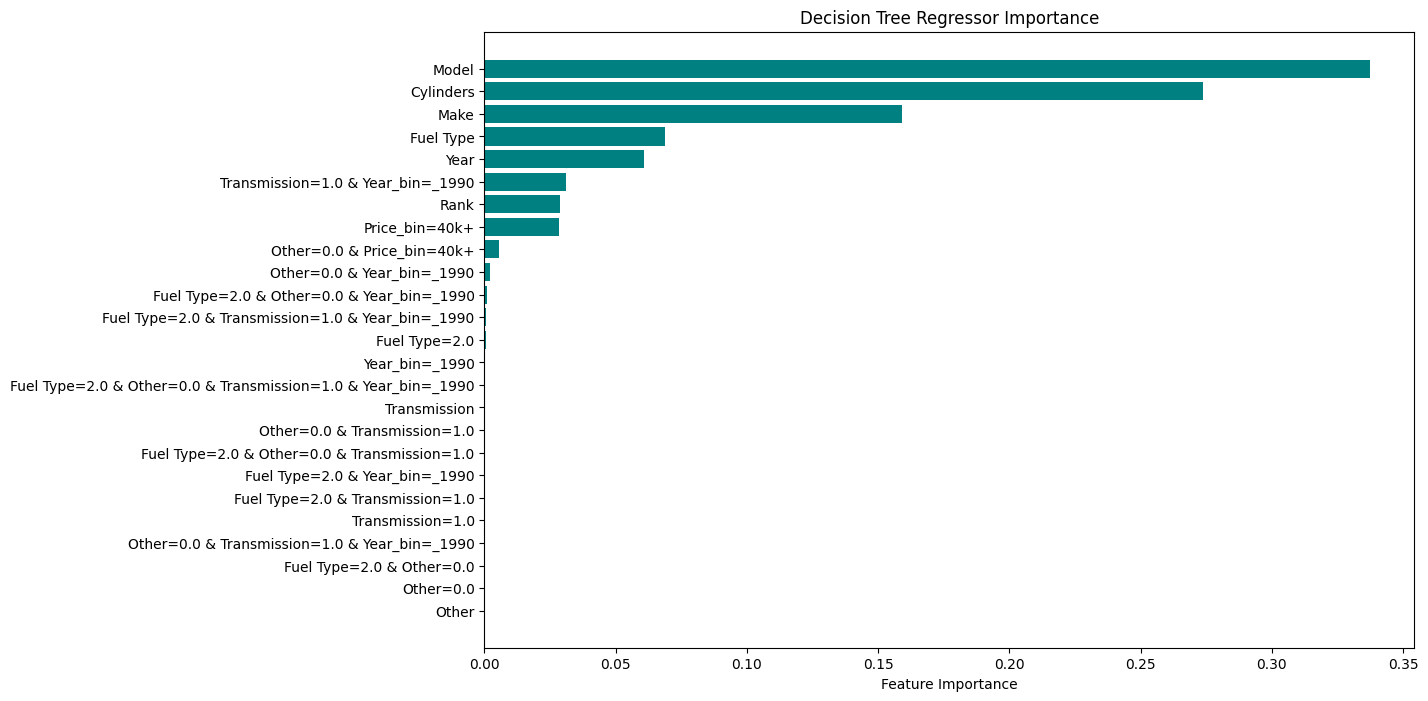

In [31]:
# acquiring feature importance
decision_tree_importances = dt.feature_importances_
decision_tree_features = X.columns

# creating feature importances dataframe
decision_tree_features_importances = pd.DataFrame({'Feature': decision_tree_features, 'Importance': decision_tree_importances})
decision_tree_features_importances = decision_tree_features_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(decision_tree_features_importances['Feature'], decision_tree_features_importances['Importance'], color='teal')
plt.xlabel('Feature Importance')
plt.title('Decision Tree Regressor Importance')
plt.gca().invert_yaxis()
plt.show()

In [61]:
 # Select top 5 features based on correlation with the target
selected_dt_features = [feature for feature, importance in zip(X.columns, decision_tree_importances) if importance > 0.05]
print("Selected Features (Decision Tree):", selected_dt_features)

Selected Features (Decision Tree): ['Make', 'Model', 'Year', 'Cylinders', 'Fuel Type']


In [62]:
# parameter grid for all three models
param_grid = {
    'XGBoost': {
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.05],
        'gamma': [0, 0.1, 0.2, 0.5],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2.0]
    },
    'RandomForestRegressor': {
        'n_estimators': [100],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'DecisionTreeRegressor': {
        'splitter': ['best', 'random'],
        'max_depth': [None, 3, 5, 7, 10, 15, 20],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': [None, 'sqrt', 'log2', 0.5, 0.8]
    }
}

In [63]:
# best parameter search and results for the decision tree regressor model
decision_tree_grid_search = GridSearchCV(dt, param_grid['DecisionTreeRegressor'], cv=5, scoring='r2', verbose=10)
decision_tree_grid_search.fit(X_train[selected_dt_features], y_train)
print("Decision Tree Regressor Best Parameters:", decision_tree_grid_search.best_params_)
print("Performance:")

Fitting 5 folds for each of 1120 candidates, totalling 5600 fits
[CV 1/5; 1/1120] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best
[CV 1/5; 1/1120] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best;, score=0.700 total time=   0.0s
[CV 2/5; 1/1120] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best
[CV 2/5; 1/1120] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best;, score=0.473 total time=   0.0s
[CV 3/5; 1/1120] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best
[CV 3/5; 1/1120] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best;, score=0.722 total time=   0.0s
[CV 4/5; 1/1120] START max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, splitter=best
[CV 4/5; 1/1120] END max_depth=None, max_features=N

In [64]:
random_forest_grid_search = GridSearchCV(RandomForestRegressor(), param_grid['RandomForestRegressor'], cv=5, scoring='r2', verbose=10)
random_forest_grid_search.fit(X_train[selected_dt_features], y_train)
print("Best Random Forest Parameters:", random_forest_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 1/27] END max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5; 1/27] START max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 1/27] END max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 1/27] START max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 1/27] END max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 1/27] START max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 4/5; 1/27] END max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5; 1/27] START max_features=auto

[CV 2/5; 9/27] END max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 9/27] START max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 3/5; 9/27] END max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 9/27] START max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 4/5; 9/27] END max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5; 9/27] START max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 5/5; 9/27] END max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 10/27] START max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 10/27] END max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators

c:\Users\elija\VSCodeLocal\Learning\Projects\DataMining\Project\AssociationRuleMiningWithLLMs\env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\elija\VSCodeLocal\Learning\Projects\DataMining\Project\AssociationRuleMiningWithLLMs\env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\elija\VSCodeLocal\Learning\Projects\DataMining\Project\AssociationRuleMiningWithLLMs\env\lib\site-packages\sklearn\base.py", line 1382, in wrapper

Best Random Forest Parameters: {'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [65]:
xgboost_grid_search = GridSearchCV(xgb, param_grid['XGBoost'], cv=5, scoring='r2', verbose=10)
xgboost_grid_search.fit(X_train[selected_dt_features], y_train)
print("XGBoost Best Parameters:", xgboost_grid_search.best_params_)
print("Performance:")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5; 1/144] START gamma=0, learning_rate=0.01, max_depth=3, reg_alpha=0, reg_lambda=1
[CV 1/5; 1/144] END gamma=0, learning_rate=0.01, max_depth=3, reg_alpha=0, reg_lambda=1;, score=0.291 total time=   0.0s
[CV 2/5; 1/144] START gamma=0, learning_rate=0.01, max_depth=3, reg_alpha=0, reg_lambda=1
[CV 2/5; 1/144] END gamma=0, learning_rate=0.01, max_depth=3, reg_alpha=0, reg_lambda=1;, score=0.216 total time=   0.0s
[CV 3/5; 1/144] START gamma=0, learning_rate=0.01, max_depth=3, reg_alpha=0, reg_lambda=1
[CV 3/5; 1/144] END gamma=0, learning_rate=0.01, max_depth=3, reg_alpha=0, reg_lambda=1;, score=0.247 total time=   0.0s
[CV 4/5; 1/144] START gamma=0, learning_rate=0.01, max_depth=3, reg_alpha=0, reg_lambda=1
[CV 4/5; 1/144] END gamma=0, learning_rate=0.01, max_depth=3, reg_alpha=0, reg_lambda=1;, score=0.405 total time=   0.1s
[CV 5/5; 1/144] START gamma=0, learning_rate=0.01, max_depth=3, reg_alpha=0, reg_lambda=1
[CV

In [81]:
stacking = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(random_state=42)),
        ('gb', DecisionTreeRegressor(random_state=42)),
        ('xgb', XGBRegressor(random_state=42))
    ],
    final_estimator=LinearRegression()
)
voting = VotingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(random_state=42)),
        ('gb', DecisionTreeRegressor(random_state=42)),
        ('xgb', XGBRegressor(random_state=42))
    ]
)

In [67]:
def evaluate_model(model, X_train, y_train, X_test, y_test, show_plot=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nModel: {model.__class__.__name__}")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²:  {r2:.2f}")
    
    if show_plot:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual Price")
        plt.ylabel("Predicted Price")
        plt.title(f"Actual vs Predicted: {model.__class__.__name__}")
        plt.tight_layout()
        plt.show()

    return y_pred


Model: DecisionTreeRegressor
MSE: 131318726385.54
MAE: 119333.23
R²:  0.50


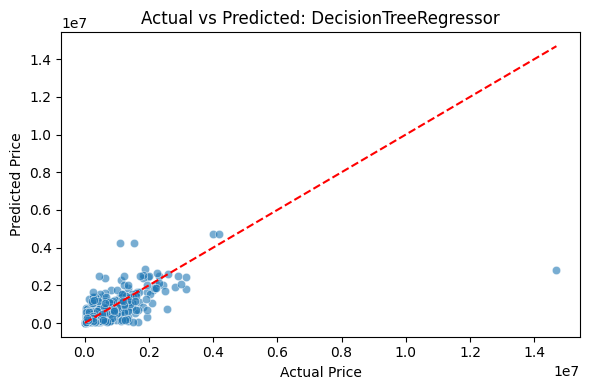

In [78]:
y_preds_dt = evaluate_model(dt, X_train, y_train, X_test, y_test)


Model: XGBRegressor
MSE: 56129478656.00
MAE: 105082.48
R²:  0.79


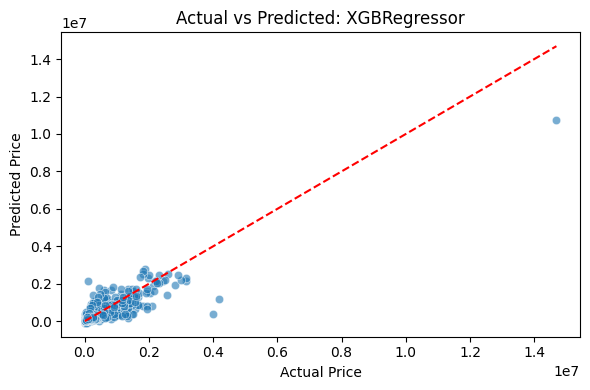

In [79]:
y_preds_xgb = evaluate_model(xgb, X_train, y_train, X_test, y_test)


Model: RFE
MSE: 80932931604.65
MAE: 103141.67
R²:  0.69


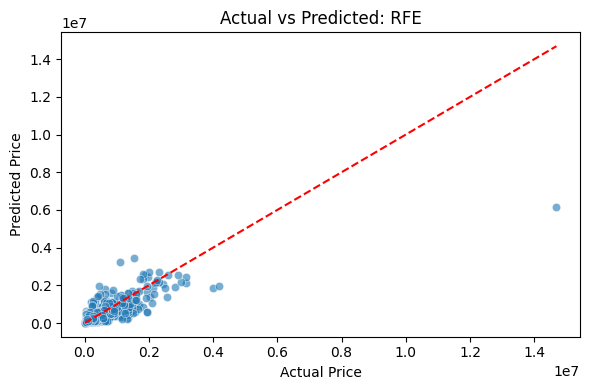

In [80]:
y_preds_rf = evaluate_model(rfe, X_train, y_train, X_test, y_test)


Model: DecisionTreeRegressor
MSE: 219598380539.55
MAE: 118591.34
R²:  0.16


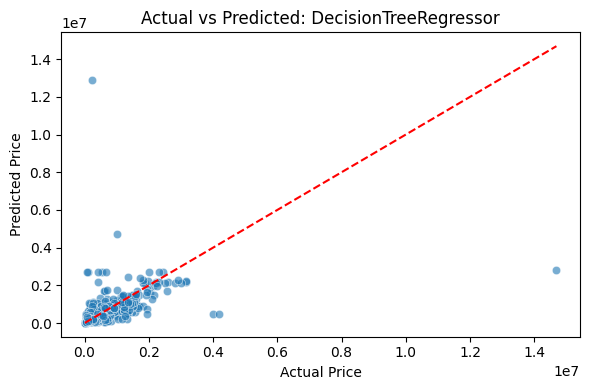

In [77]:
y_preds_dt = evaluate_model(decision_tree_grid_search.best_estimator_, X_train, y_train, X_test, y_test)


Model: XGBRegressor
MSE: 68829872128.00
MAE: 120629.17
R²:  0.74


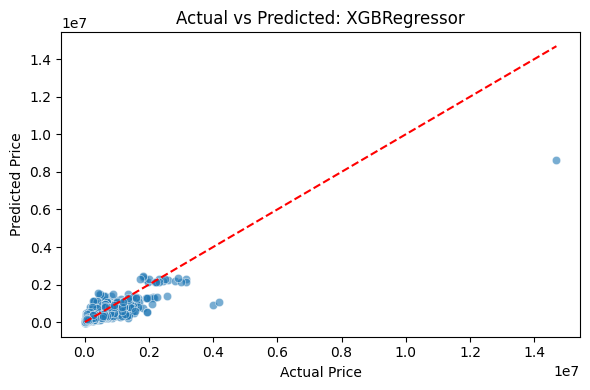

In [69]:
y_preds_xgb = evaluate_model(xgboost_grid_search.best_estimator_, X_train, y_train, X_test, y_test)


Model: RandomForestRegressor
MSE: 135955174049.54
MAE: 121102.04
R²:  0.48


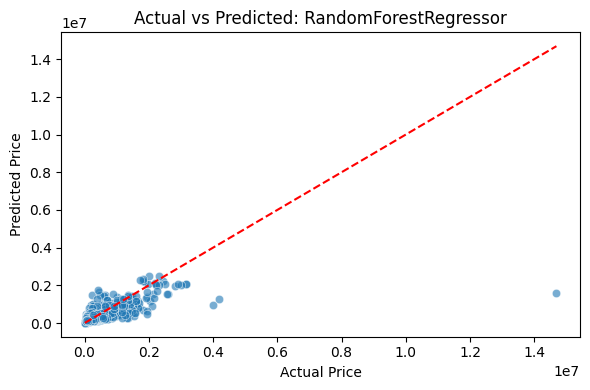

In [70]:
y_preds_rf = evaluate_model(random_forest_grid_search.best_estimator_, X_train, y_train, X_test, y_test)



Stacking Regressor Performance:

Model: StackingRegressor
MSE: 68752489494.23
MAE: 102228.25
R²:  0.74


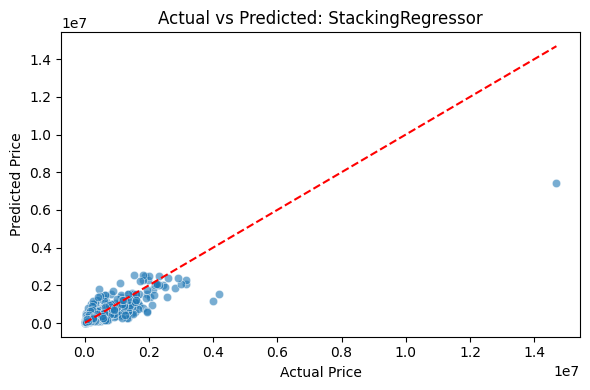

In [82]:
print("\nStacking Regressor Performance:")
y_pred_stacking = evaluate_model(stacking, X_train, y_train, X_test, y_test)


Voting Regressor Performance:

Model: VotingRegressor
MSE: 74280730623.72
MAE: 103150.46
R²:  0.72


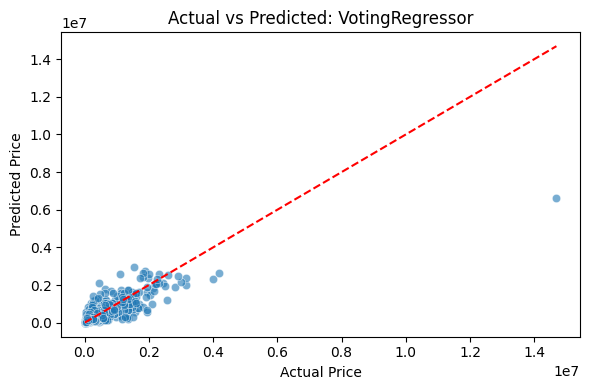

In [83]:
print("\nVoting Regressor Performance:")
y_pred_voting = evaluate_model(voting, X_train, y_train, X_test, y_test)

In [84]:
from sklearn.model_selection import cross_val_score

In [85]:
print("\nCross-Validation (Random Forest):")
scores = cross_val_score(random_forest_grid_search.best_estimator_, X, y, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", scores)
print("Average R² Score:", np.mean(scores))


Cross-Validation (Random Forest):


Cross-Validation R² Scores: [0.59066397 0.45795131 0.65332696 0.42962422 0.65150955]
Average R² Score: 0.5566152017150363
